## III/ MRI_T2 Images

### Imports

In [1]:
import os
import shutil
import subprocess

import numpy as np
import cv2
import matplotlib.pyplot as plt

import nibabel as nib
from collections import defaultdict

from skimage.transform import resize
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_objects, ball, binary_closing
from scipy.ndimage import label, binary_fill_holes

### display the original images (NiFTI)

In [3]:
def display_nifti_img(data, ax=None, title="", axis="z"):
    # Take middle slice in x-axis
    if axis == "x":
        x_middle = data.shape[0] // 2
        slice_img = data[x_middle, :, :]

    # Take middle slice in y-axis
    elif axis == "y":
        y_middle = data.shape[1] // 2
        slice_img = data[:, y_middle, :]

    # Take middle slice in z-axis
    else:
        z_middle = data.shape[2] // 2
        slice_img = data[:, :, z_middle]

    if ax is None:
        # Display standalone
        plt.imshow(np.rot90(slice_img), cmap='gray')
        plt.title(title)
        plt.axis('off')
        plt.show()
    else:
        # Display in provided axis
        ax.imshow(np.rot90(slice_img), cmap='gray')
        ax.set_title(title)
        ax.axis('off')

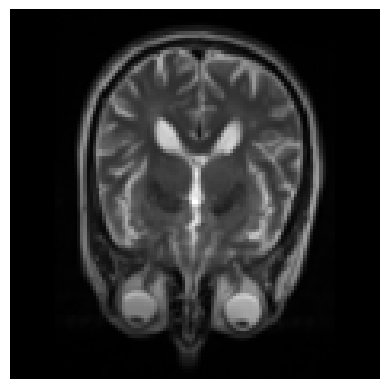

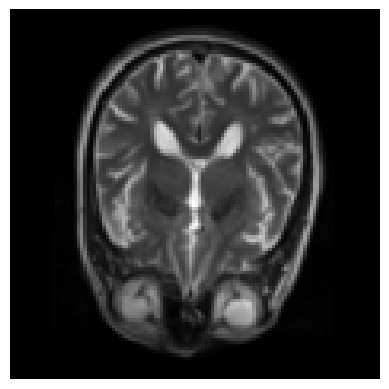

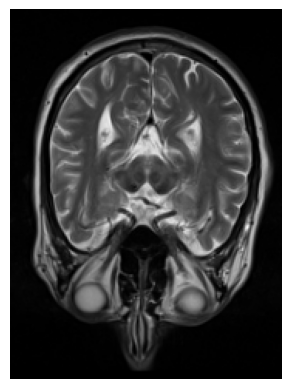

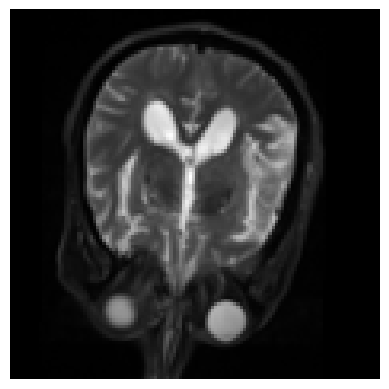

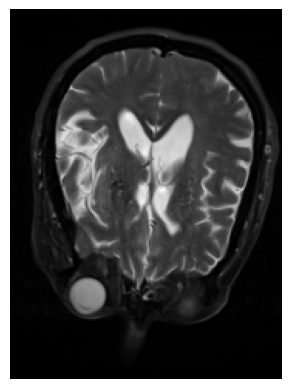

In [4]:
base_path = "Dataset/mri_t2_images/PPMI_mri_t2"
# base_path = "Dataset/mri_t2_images/3_Paired_MRI_T2" #* after pairing

displayed_count = 0
MAX_DISPLAYED = 5

for patient_id in os.listdir(base_path):
    patient_path = os.path.join(base_path, patient_id)
    if not os.path.isdir(patient_path):
        continue

    for scan_type in os.listdir(patient_path):
        scan_type_path = os.path.join(patient_path, scan_type)
        if not os.path.isdir(scan_type_path):
            continue

        for scan_date in os.listdir(scan_type_path):
            scan_date_path = os.path.join(scan_type_path, scan_date)
            if not os.path.isdir(scan_date_path):
                continue

            for image_id in os.listdir(scan_date_path):
                image_folder_path = os.path.join(scan_date_path, image_id)
                if not os.path.isdir(image_folder_path):
                    continue

                for file in os.listdir(image_folder_path):
                    if file.lower().endswith(".nii"):
                        nifti_file = os.path.join(image_folder_path, file)
                        img = nib.load(nifti_file)
                        data = img.get_fdata()
                        display_nifti_img(data, ax=None, title="", axis="z")
                        displayed_count += 1
                        break

                if displayed_count >= MAX_DISPLAYED:
                    break
            if displayed_count >= MAX_DISPLAYED:
                break
        if displayed_count >= MAX_DISPLAYED:
            break
    if displayed_count >= MAX_DISPLAYED:
        break

### 0. Cleanup the folder hierarchy

In [7]:
# Base input and output paths
src_root = "Dataset/mri_t2_images/PPMI_mri_t2"
dst_root = "Dataset/mri_t2_images/PPMI_mri_t2_flat(not paired)"
os.makedirs(dst_root, exist_ok=True)


for patient_id in os.listdir(src_root):
    patient_path = os.path.join(src_root, patient_id)
    if not os.path.isdir(patient_path):
        continue  # skip non-folder items

    dst_patient_dir = os.path.join(dst_root, patient_id)
    os.makedirs(dst_patient_dir, exist_ok=True)

    # Walk through all nested folders for this patient
    for root, dirs, files in os.walk(patient_path):
        for file in files:
            if file.endswith(".nii"):
                image_id = os.path.basename(os.path.dirname(root))
                # If image_id is actually deeper, extract correctly
                if not image_id.startswith("I"):
                    image_id = os.path.basename(root)

                dst_file = os.path.join(dst_patient_dir, f"{image_id}.nii")

                src_file = os.path.join(root, file)
                if not os.path.exists(dst_file):
                    shutil.copy2(src_file, dst_file)
                else:
                    print(f"⚠️ Duplicate image ID skipped: {dst_file}")

print("✅ Reorganization complete. Check:", dst_root)


✅ Reorganization complete. Check: Dataset/mri_t2_images/PPMI_mri_t2_flat(not paired)


### 1. Skull Stripping 

#### Option 01: HD-BET Tool

In [ ]:
total_images = sum(
    1 for root, _, files in os.walk(base_path)
    for f in files if f.endswith(".nii") or f.endswith(".nii.gz")
)
processed_count = 0
displayed_count = 0
failed_skullstrip = []

skullstripped_path = "Dataset/mri_t2_images/SkullStripped_mri_t2(HD-BET)"
os.makedirs(skullstripped_path, exist_ok=True)


for patient_id in os.listdir(base_path):
    patient_path = os.path.join(base_path, patient_id)
    if not os.path.isdir(patient_path):
        continue

    for root, _, files in os.walk(patient_path):
            for file in files:
                if not (file.endswith(".nii") or file.endswith(".nii.gz")):
                    continue

                processed_count += 1

                image_id = os.path.splitext(os.path.splitext(file)[0])[0]
                # print("\nimage_id:",image_id)
                input_path = os.path.join(root, file)
                # print("\ninput_path:",input_path)

                # Output folder
                patient_output_dir = os.path.join(skullstripped_path, patient_id)
                os.makedirs(patient_output_dir, exist_ok=True)
                output_file = os.path.join(patient_output_dir, file)
                # print("\noutput_file:",output_file)


                print(f"[{processed_count}/{total_images}] Skull-stripping: patient {patient_id} - image {image_id}...")

                try:
                    # Run HD-BET command-line tool
                    # hd-bet -i input.nii.gz -o output.nii.gz -device cpu -mode fast
                    subprocess.run([
                        "hd-bet",
                        "-i", input_path,
                        "-o", output_file,
                        # "-o", patient_output_dir,
                        "-device", "cpu",
                        "--disable_tta", # disables test time augmentation, which speeds up processing by 8x on CPU
                        # "-mode", "fast" # faster mode
                    ],  check=True, 
                        # timeout=300
                    )

                    # Display BEFORE/AFTER
                    if displayed_count < MAX_DISPLAYED:
                        # Load original and skull-stripped results
                        img_before = nib.load(input_path).get_fdata()
                        img_after = nib.load(output_file).get_fdata()

                        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
                        plt.suptitle(f"Patient {patient_id} - Image {image_id}")
                        display_nifti_img(img_before, ax=axes[0], title="Before")
                        display_nifti_img(img_after, ax=axes[1], title="After Skull-Stripping")

                        plt.tight_layout()
                        plt.show()

                        displayed_count += 1

                except Exception as e:
                    print(f"[✘] Failed to skull-strip {patient_id}/{image_id}: {e}")
                    failed_skullstrip.append(f"{patient_id}/{image_id}")


# === FINAL SUMMARY ===
print("\n" + "=" * 50)
if not failed_skullstrip:
    print("✅ All images skull-stripped successfully!")
else:
    print(f"⚠ {len(failed_skullstrip)} images failed to skull-strip:")
    for img_name in failed_skullstrip:
        print(f" - {img_name}")


[1/98] Skull-stripping: patient 3107 - image I429657...


#### Option 02: Otsu initial threshold → connected component analysis → morphological operations → hole filling → closing


[1/721] Skull-stripping: patient 3104 - image I303484...


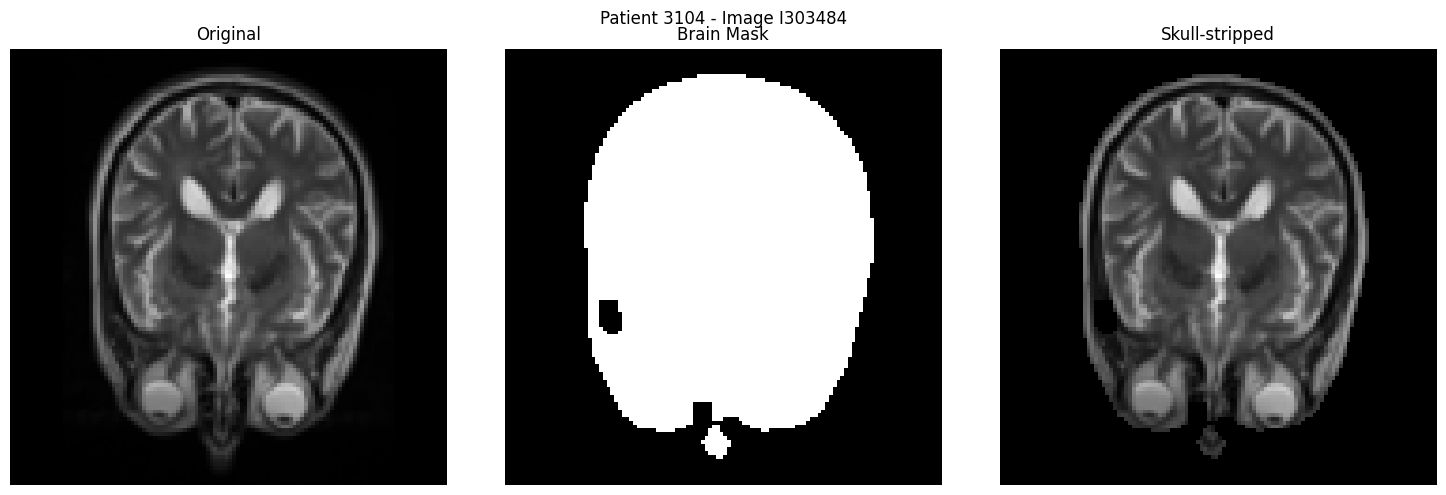


[2/721] Skull-stripping: patient 3104 - image I303495...


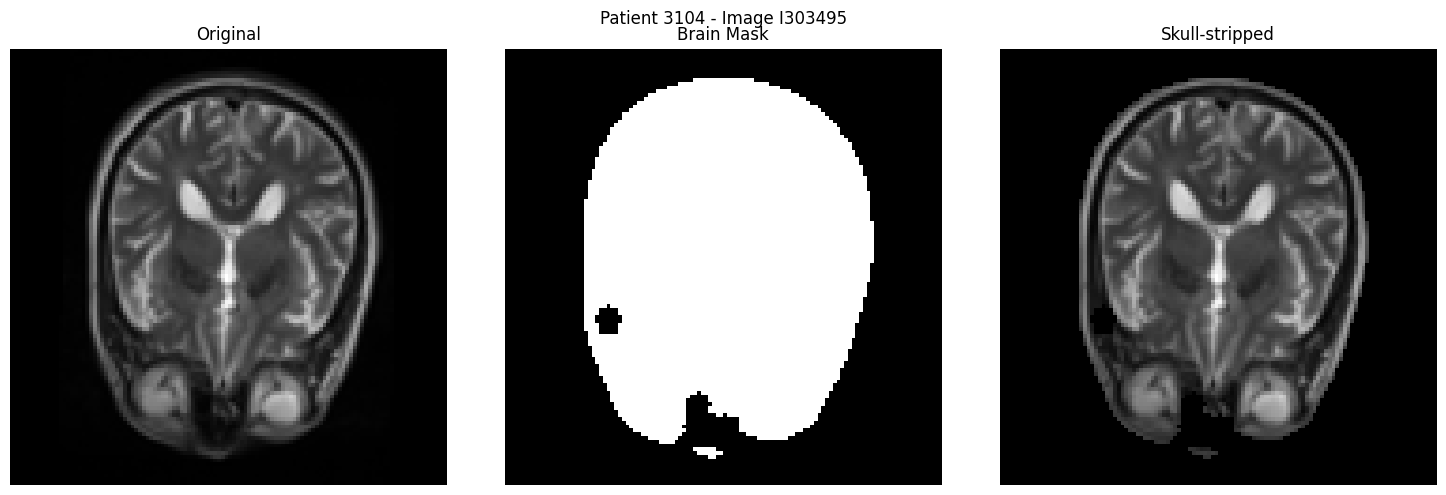


[3/721] Skull-stripping: patient 3104 - image I330131...


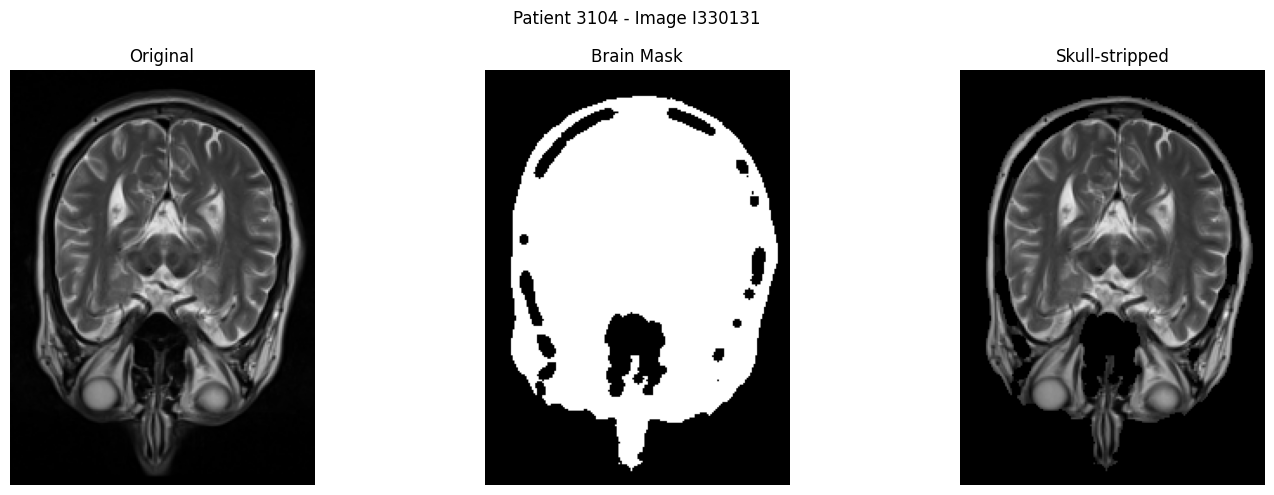


[4/721] Skull-stripping: patient 3105 - image I406732...


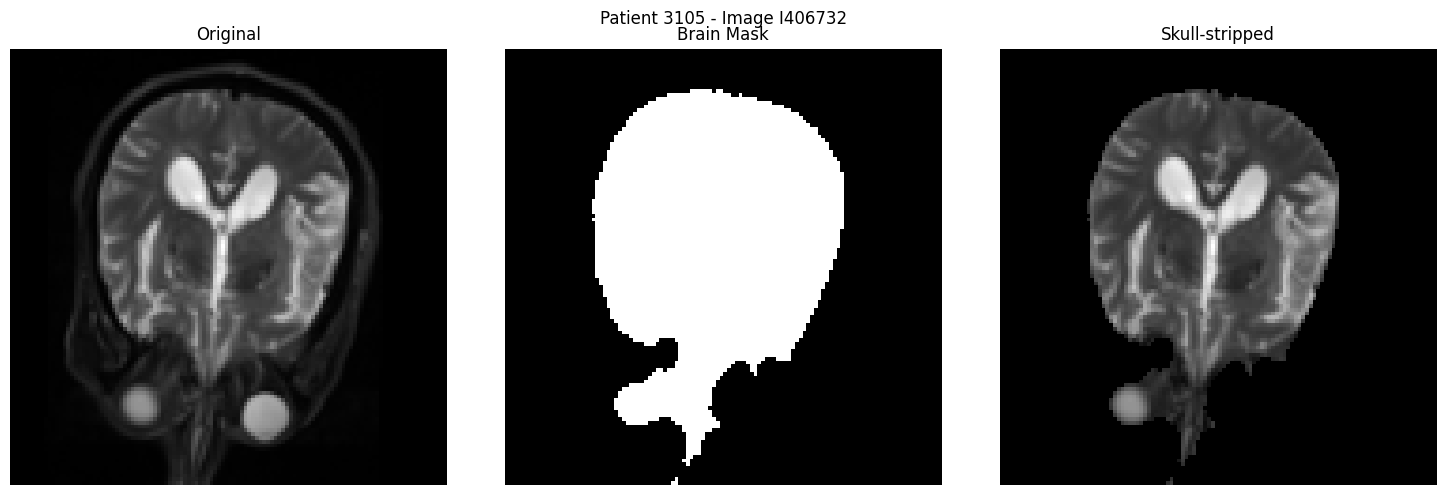


[5/721] Skull-stripping: patient 3105 - image I406740...


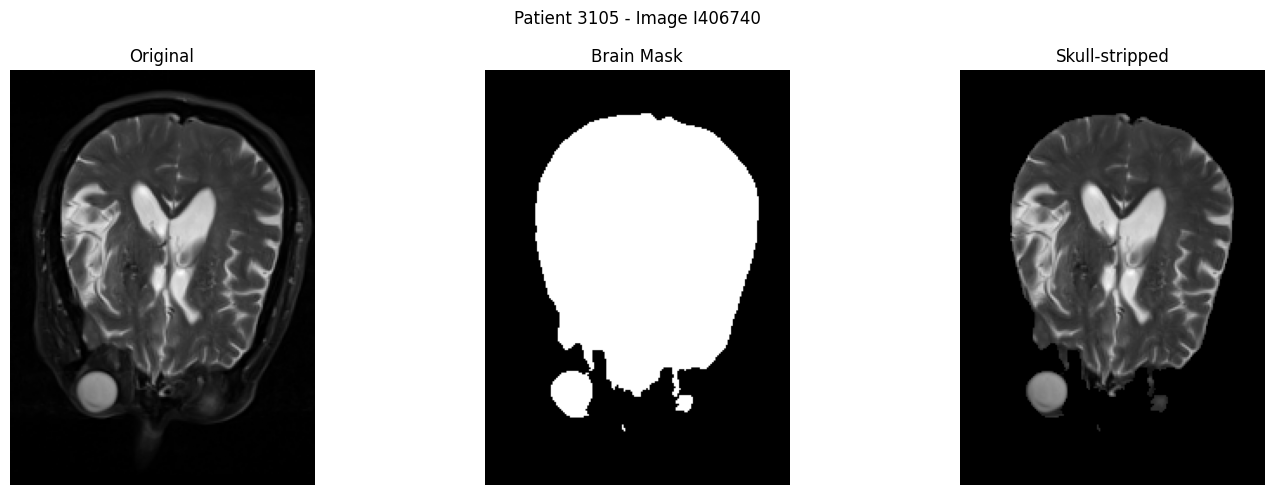


[6/721] Skull-stripping: patient 3107 - image I304299...

[7/721] Skull-stripping: patient 3107 - image I304310...

[8/721] Skull-stripping: patient 3107 - image I330465...

[9/721] Skull-stripping: patient 3107 - image I429657...

[10/721] Skull-stripping: patient 3107 - image I429659...

[11/721] Skull-stripping: patient 3107 - image I693251...

[12/721] Skull-stripping: patient 3107 - image I696120...

[13/721] Skull-stripping: patient 3108 - image I330490...

[14/721] Skull-stripping: patient 3108 - image I333077...

[15/721] Skull-stripping: patient 3108 - image I407127...

[16/721] Skull-stripping: patient 3111 - image I291970...

[17/721] Skull-stripping: patient 3111 - image I291981...

[18/721] Skull-stripping: patient 3111 - image I330504...

[19/721] Skull-stripping: patient 3112 - image I291992...

[20/721] Skull-stripping: patient 3112 - image I292003...

[21/721] Skull-stripping: patient 3112 - image I330517...

[22/721] Skull-stripping: patient 3113 - image I370195...


KeyboardInterrupt: 

In [ ]:
total_images = sum(
    1 for root, dirs, files in os.walk(base_path)
    for file in files if file.endswith(".nii") or file.endswith(".nii.gz")
)
processed_count = 0
displayed_count = 0
failed_skullstrip = []

skullstripped_path = "Dataset/mri_t2_images/SkullStripped_mri_t2_v2"
os.makedirs(skullstripped_path, exist_ok=True)


# Helper: Skull-stripping function (3D)
def skull_strip_volume(volume,
                       min_frac_smallobj=0.001,   # remove very tiny components
                       closing_radius=3,          # radius for 3D closing (in voxels)
                       keep_largest=True):
    """
    Perform skull-stripping inspired by the described paper:
    - start with Otsu threshold (global)
    - threshold volume, label connected components (3D)
    - keep the brain component(s), remove non-brain components by size (keep largest)
    - fill holes and apply morphological closing to smooth boundaries
    Returns: brain_mask (bool array), skull_stripped_volume (float)
    """
    # Ensure float
    vol = volume.astype(np.float32)

    # If volume is constant, return empty mask / original
    if vol.max() == vol.min():
        return np.zeros_like(vol, dtype=bool), vol

    # Compute initial threshold using Otsu on non-zero voxels (or full volume if all nonzero)
    try:
        # Prefer using the brain region intensity distribution: use all voxels
        t = threshold_otsu(vol)
    except Exception:
        # fallback to simple median if Otsu fails
        t = np.median(vol)

    # Binary image by threshold (brain often has intermediate intensities; threshold>t)
    binary = vol > t

    # Label 3D connected components
    labeled, ncomp = label(binary)
    if ncomp == 0:
        # Nothing detected — return empty mask to avoid crash
        return np.zeros_like(vol, dtype=bool), vol

    # Compute sizes of connected components
    comp_ids, counts = np.unique(labeled[labeled > 0], return_counts=True)
    # If no positive components, fallback
    if comp_ids.size == 0:
        return np.zeros_like(vol, dtype=bool), vol

    # Keep the largest component (assumed brain) — this removes skull/non-brain pieces
    largest_idx = comp_ids[np.argmax(counts)]
    brain_mask = (labeled == largest_idx)

    # Remove tiny stray objects if any (3D)
    min_size_voxels = max(1, int(min_frac_smallobj * vol.size))
    brain_mask = remove_small_objects(brain_mask.astype(bool), min_size=min_size_voxels)

    # Fill holes in 3D (binary_fill_holes operates on N-D arrays)
    brain_mask = binary_fill_holes(brain_mask)

    # Morphological closing (3D) to smooth and close small gaps
    selem = ball(closing_radius)  # spherical structuring element
    brain_mask = binary_closing(brain_mask, selem)

    # Final safety: ensure mask is boolean and has at least some voxels
    if brain_mask.sum() == 0:
        # fallback: loosen threshold by lowering it by 10% and try again once
        t2 = t * 0.9
        binary2 = vol > t2
        labeled2, n2 = label(binary2)
        if n2 > 0:
            comp_ids2, counts2 = np.unique(labeled2[labeled2 > 0], return_counts=True)
            largest_idx2 = comp_ids2[np.argmax(counts2)]
            brain_mask = labeled2 == largest_idx2
            brain_mask = binary_fill_holes(brain_mask)
            brain_mask = binary_closing(brain_mask, selem)
        else:
            # final fallback: return original vol mask > median
            m = np.median(vol)
            brain_mask = vol > m
            brain_mask = binary_fill_holes(brain_mask)
            brain_mask = binary_closing(brain_mask, selem)

    # Apply mask to volume
    skull_stripped = vol * brain_mask

    return brain_mask.astype(bool), skull_stripped


for patient_id in os.listdir(base_path):
    patient_path = os.path.join(base_path, patient_id)
    if not os.path.isdir(patient_path):
        continue

    for file in os.listdir(patient_path):
        if file.endswith(".nii") or file.endswith(".nii.gz"):
            processed_count += 1

            image_id = os.path.splitext(os.path.splitext(file)[0])[0]

            print(f"\n[{processed_count}/{total_images}] Skull-stripping: patient {patient_id} - image {image_id}...")

            input_path = os.path.join(patient_path, file)

            # Output folder
            patient_output_dir = os.path.join(skullstripped_path, patient_id)
            os.makedirs(patient_output_dir, exist_ok=True)
            output_file = os.path.join(patient_output_dir, f"{image_id}.nii.gz")

            try:
                # Load image
                img = nib.load(input_path)
                data = img.get_fdata()

                # Optionally reorient here if you suspect inconsistent orientations.
                # For simplicity we assume volumes are already consistently oriented.
                # If you want to enforce RAS orientation:
                # from nibabel.orientations import io_orientation, axcodes2ornt, ornt_transform, apply_orientation

                # Run skull-stripping
                brain_mask, skull_stripped = skull_strip_volume(
                                                data,
                                                min_frac_smallobj=0.0005,
                                                closing_radius=3
                                            )

                # print("Mask voxels:", brain_mask.sum())

                # Display BEFORE/AFTER
                if displayed_count < MAX_DISPLAYED:
                    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
                    plt.suptitle(f"Patient {patient_id} - Image {image_id}")

                    # original middle slice
                    display_nifti_img(data, ax=axes[0], title="Original")
                    # binary mask middle slice (visualize mask)
                    display_nifti_img(brain_mask.astype(np.uint8), ax=axes[1], title="Brain Mask")
                    # skull-stripped middle slice
                    display_nifti_img(skull_stripped, ax=axes[2], title="Skull-stripped")

                    plt.tight_layout()
                    plt.show()

                    displayed_count += 1

                # Save skull-stripped volume
                nib.save(
                    nib.Nifti1Image(skull_stripped.astype(np.float32), affine=img.affine, header=img.header),
                    output_file
                )

            except Exception as e:
                print(f"[✘] Failed to skull-strip {patient_id}/{image_id}: {e}")
                failed_skullstrip.append(f"{patient_id}/{image_id}")


# ---------------------------
# Final summary
# ---------------------------
print("\n" + "=" * 50)
if not failed_skullstrip:
    print("✅ All images skull-stripped successfully.")
else:
    print(f"⚠ {len(failed_skullstrip)} images failed to skull-strip:")
    for img_name in failed_skullstrip:
        print(f" - {img_name}")

### 2. Noise Removal (Bilateral filter); skipped

In [ ]:
total_images = sum(
    1 for root, dirs, files in os.walk(skullstripped_path)
    for file in files if file.endswith(".nii") or file.endswith(".nii.gz")
)
processed_count = 0
displayed_count = 0
failed_filtering = []

filtered_path = "Dataset/mri_t2_images/Filtered_mri_t2"
os.makedirs(filtered_path, exist_ok=True)


# Bilateral filter parameters
d = 5            # neighborhood diameter
sigmaColor = 50  # larger = more smoothing
sigmaSpace = 50  # spatial distance sensitivity

# Helper: apply bilateral filter slice by slice
def apply_bilateral_filter(volume):
    filtered = np.zeros_like(volume)
    for i in range(volume.shape[2]):  # iterate over slices
        slice_img = volume[:, :, i].astype(np.float32)
        
        # Normalize to 0-255 for OpenCV
        slice_norm = cv2.normalize(slice_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        
        # Apply bilateral filter
        slice_filtered = cv2.bilateralFilter(slice_norm, d, sigmaColor, sigmaSpace)
        
        # Scale back to original range (float32)
        slice_filtered = slice_filtered.astype(np.float32) / 255.0 * (slice_img.max() - slice_img.min()) + slice_img.min()
        
        filtered[:, :, i] = slice_filtered
    return filtered


for patient_id in os.listdir(skullstripped_path):
    patient_path = os.path.join(skullstripped_path, patient_id)
    if not os.path.isdir(patient_path):
        continue

    for file in os.listdir(patient_path):
        if not (file.endswith(".nii") or file.endswith(".nii.gz")):
            continue

        processed_count += 1
        img_id = os.path.splitext(os.path.splitext(file)[0])[0]
        print(f"\n[{processed_count}/{total_images}] Filtering: patient {patient_id} - image {img_id}...")

        input_path = os.path.join(patient_path, file)

        # Output folder
        patient_output_dir = os.path.join(filtered_path, patient_id)
        os.makedirs(patient_output_dir, exist_ok=True)
        output_file = os.path.join(patient_output_dir, file)

        try:
            # Load image
            img = nib.load(input_path)
            data = img.get_fdata()

            # Apply bilateral filtering
            filtered_data = apply_bilateral_filter(data)

            # Display BEFORE/AFTER
            if displayed_count < MAX_DISPLAYED:
                fig, axes = plt.subplots(1, 2, figsize=(10, 5))
                plt.suptitle(f"Patient {patient_id} - Image {image_id}")

                display_nifti_img(data, ax=axes[0], title="Before")
                display_nifti_img(filtered_data, ax=axes[1], title="After After Bilateral Filter")

                plt.tight_layout()
                plt.show()

                displayed_count += 1

            # Save filtered NIfTI image
            nib.save(
                nib.Nifti1Image(filtered_data, affine=img.affine, header=img.header),
                output_file
            )

        except Exception as e:
            print(f"[✘] Failed to filter {patient_id}/{img_id}: {e}")
            failed_filtering.append(f"{patient_id}/{img_id}")


# === FINAL SUMMARY ===
print("\n" + "=" * 50)
if not failed_filtering:
    print("✅ All images filtered successfully.")
else:
    print(f"⚠ {len(failed_filtering)} images failed to filter:")
    for img_name in failed_filtering:
        print(f" - {img_name}")


### 3. Normalizing (Z-score)


[1/721] Normalizing: patient 3104 - image I303484...


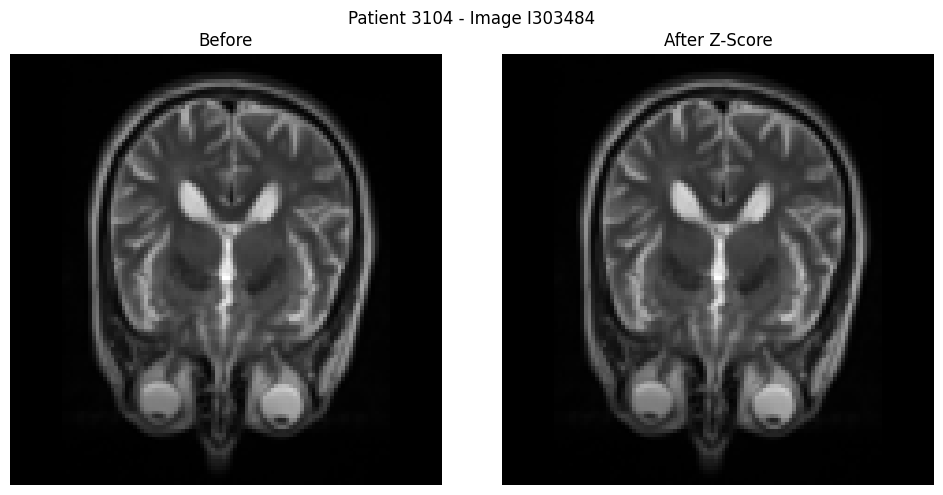


[2/721] Normalizing: patient 3104 - image I303495...


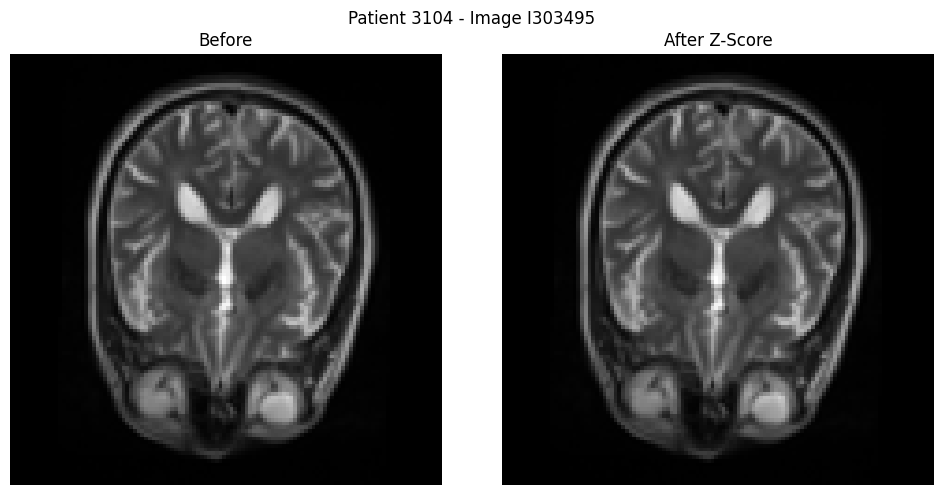


[3/721] Normalizing: patient 3104 - image I330131...


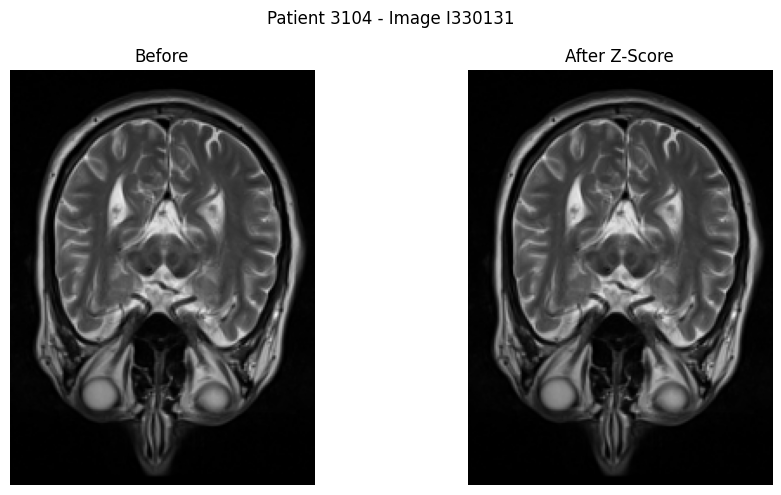


[4/721] Normalizing: patient 3105 - image I406732...


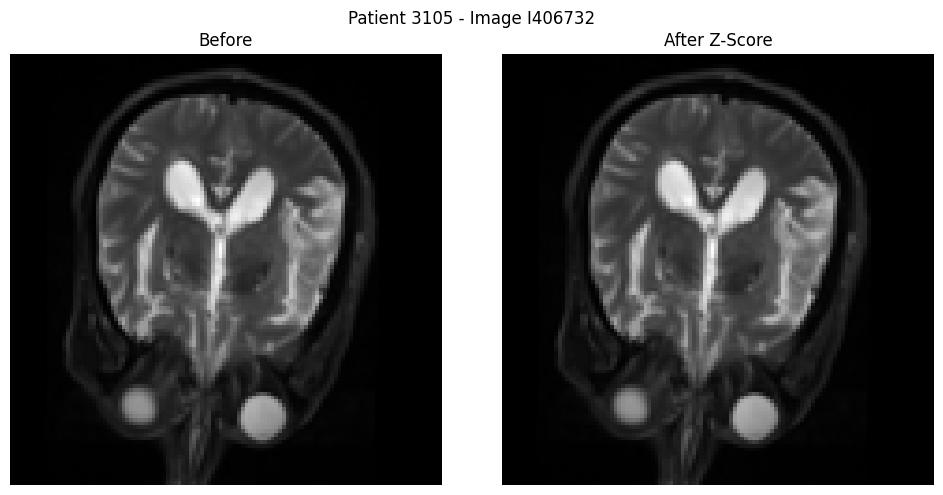


[5/721] Normalizing: patient 3105 - image I406740...


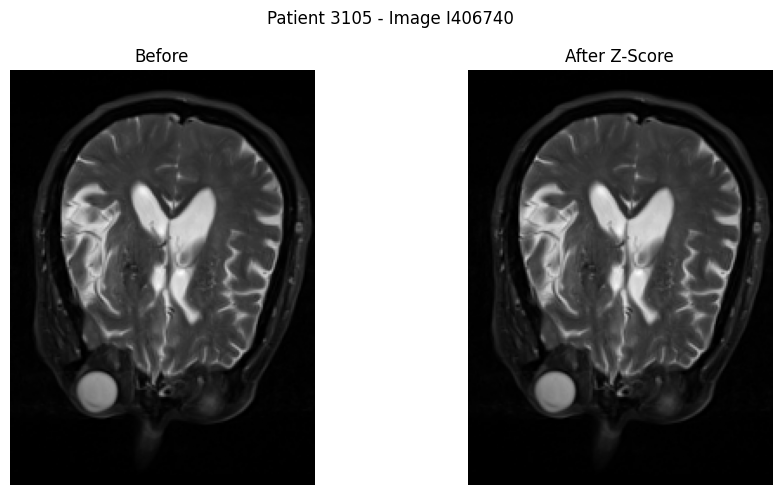


[6/721] Normalizing: patient 3107 - image I304299...

[7/721] Normalizing: patient 3107 - image I304310...

[8/721] Normalizing: patient 3107 - image I330465...

[9/721] Normalizing: patient 3107 - image I429657...

[10/721] Normalizing: patient 3107 - image I429659...

[11/721] Normalizing: patient 3107 - image I693251...

[12/721] Normalizing: patient 3107 - image I696120...

[13/721] Normalizing: patient 3108 - image I330490...

[14/721] Normalizing: patient 3108 - image I333077...

[15/721] Normalizing: patient 3108 - image I407127...

[16/721] Normalizing: patient 3111 - image I291970...

[17/721] Normalizing: patient 3111 - image I291981...

[18/721] Normalizing: patient 3111 - image I330504...

[19/721] Normalizing: patient 3112 - image I291992...

[20/721] Normalizing: patient 3112 - image I292003...

[21/721] Normalizing: patient 3112 - image I330517...

[22/721] Normalizing: patient 3113 - image I370195...

[23/721] Normalizing: patient 3113 - image I406913...

[24/721] Norm

In [9]:
base_path = "Dataset/mri_t2_images/PPMI_mri_t2_flat(not paired)"

total_images = sum(
    1 for root, dirs, files in os.walk(base_path)
    for file in files if file.endswith(".nii") or file.endswith(".nii.gz")
)
processed_count = 0
displayed_count = 0
failed_normalization = []

normalized_path = "Dataset/mri_t2_images/Normalized_mri_t2(not paired)"
os.makedirs(normalized_path, exist_ok=True)

for patient_id in os.listdir(base_path):
    patient_path = os.path.join(base_path, patient_id)
    if not os.path.isdir(patient_path):
        continue

    for file in os.listdir(patient_path):
        if not (file.endswith(".nii") or file.endswith(".nii.gz")):
            continue
    
        processed_count += 1

        image_id = os.path.splitext(os.path.splitext(file)[0])[0]
        print(f"\n[{processed_count}/{total_images}] Normalizing: patient {patient_id} - image {image_id}...")

        input_path = os.path.join(patient_path, file)

        # Output folder
        patient_output_dir = os.path.join(normalized_path, patient_id)
        os.makedirs(patient_output_dir, exist_ok=True)
        output_file = os.path.join(patient_output_dir, file)

        try:
            # Load image
            img = nib.load(input_path)
            data = img.get_fdata()

            # Z-score normalization
            mean = np.mean(data)
            std = np.std(data)

            if std == 0:
                print(f"[⚠] Std=0 for patient {patient_id} - image {image_id}, skipping normalization.")
                normalized_data = data - mean
            else:
                normalized_data = (data - mean) / std

            # Display BEFORE/AFTER
            if displayed_count < MAX_DISPLAYED:
                fig, axes = plt.subplots(1, 2, figsize=(10, 5))
                plt.suptitle(f"Patient {patient_id} - Image {image_id}")

                display_nifti_img(data, ax=axes[0], title="Before")
                display_nifti_img(normalized_data, ax=axes[1], title="After Z-Score")

                plt.tight_layout()
                plt.show()
                
                displayed_count += 1

            # Save new NIfTI image with proper data type
            nib.save(
                nib.Nifti1Image(normalized_data, affine=img.affine, header=img.header),
                    output_file
            )
            
        except Exception as e:
            print(f"[✘] Failed to normalize {patient_id}/{image_id}: {e}")
            failed_normalization.append(f"{patient_id}/{image_id}")


# === FINAL SUMMARY ===
print("\n" + "=" * 50)
if not failed_normalization:
    print("✅ All images normalized successfully.")
else:
    print(f"⚠ {len(failed_normalization)} images failed to normalize:")
    for img_name in failed_normalization:
        print(f" - {img_name}")

### 4. Resizing

In [ ]:
base_path = "Dataset/mri_t2_images/PPMI_mri_t2"

# Store results
shape_counts = defaultdict(int)
orientation_counts = defaultdict(int)
failed = []

# Traverse the folder structure
for root, dirs, files in os.walk(base_path):
    for file in files:
        if file.endswith(".nii") or file.endswith(".nii.gz"):
            filepath = os.path.join(root, file)

            try:
                img = nib.load(filepath)
                shape = img.shape
                affine = img.affine
                orient = nib.aff2axcodes(affine)

                # Count occurrences
                shape_counts[shape] += 1
                orientation_counts[orient] += 1

                # Print details for each image
                # print("=" * 60)
                # print(f"File: {filepath}")
                # print("Shape:", shape)
                # print("Affine:\n", affine)
                # print("Orientation:", orient)

            except Exception as e:
                print(f"[✘] Failed to process {filepath}: {e}")
                failed.append(filepath)

# === FINAL SUMMARY ===
print("\n" + "=" * 60)
print("Summary of Shapes:")
for shape, count in shape_counts.items():
    print(f"  {shape}: {count} images")

print("\nSummary of Orientations:")
for orient, count in orientation_counts.items():
    print(f"  {orient}: {count} images")

if failed:
    print(f"\n⚠ Failed to analyze {len(failed)} images:")
    for f in failed:
        print(" -", f)
else:
    print("\n✅ All images analyzed successfully.")



Summary of Shapes:
  (116, 116, 72): 373 images
  (176, 240, 256): 264 images
  (256, 240, 176): 4 images
  (116, 116, 80): 1 images
  (116, 116, 77): 4 images
  (192, 240, 256): 13 images
  (116, 116, 76): 3 images
  (176, 256, 256): 48 images
  (116, 116, 74): 4 images
  (175, 240, 256): 3 images
  (116, 106, 72): 1 images
  (256, 256, 176): 1 images
  (116, 116, 73): 2 images

Summary of Orientations:
  ('L', 'P', 'S'): 721 images

✅ All images processed successfully.


In [ ]:
# FOR TESTING
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.transform import resize
# target_shape = (256, 256, 72)
# target_shape = (240, 240, 72)
# target_shape = (240, 176, 256) # from an article
target_shape = (224, 224, 128)
# target_shape = (224, 224, 72)
# target_shape = (128, 128, 72)
# target_shape = (116, 116, 72)
data_dir = "Dataset/mri_t2_images/PPMI_mri_t2"
file_list = []
for root, dirs, files in os.walk(data_dir):
    for f in files:
        if f.endswith(".nii") or f.endswith(".nii.gz"):
            file_list.append(os.path.join(root, f))
print(f"Found {len(file_list)} NIfTI files")
shape_dict = {}
for file in file_list:
    try:
        img = nib.load(file)
        shape = img.shape
        if len(shape) == 3 and shape not in shape_dict:
            shape_dict[shape] = file
    except Exception as e:
        print(f"Skipping {file}: {e}")
def preprocess_image(img_data, target_shape):
    img_data = img_data.astype(np.float32)

    resized = resize(
        img_data,
        target_shape,
        order=1,
        mode="constant",
        cval=0,
        anti_aliasing=True
    )
    return resized
if len(shape_dict) > 0:
    fig, axes = plt.subplots(len(shape_dict), 2, figsize=(8, 3*len(shape_dict)))

    if len(shape_dict) == 1:
        axes = [axes]

    for i, (shape, file) in enumerate(shape_dict.items()):
        img = nib.load(file)
        data = img.get_fdata()
        resized = preprocess_image(data, target_shape)

        display_nifti_img(data, ax=axes[i][0], title=f"Original {shape}", axis="z")
        display_nifti_img(resized, ax=axes[i][1], title=f"Resized {target_shape}", axis="z")

    plt.tight_layout()
    plt.show()
else:
    print("No 3D NIfTI images found in the dataset.")


[1/721] Resizing: patient 3104 - image I303484...
Original Shape: (116, 116, 72)
Resized Shape: (224, 224, 128)


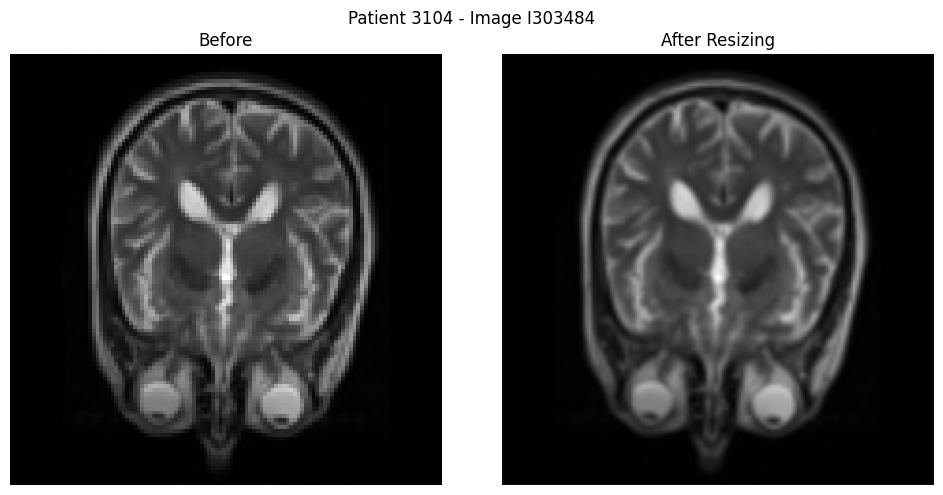


[2/721] Resizing: patient 3104 - image I303495...
Original Shape: (116, 116, 72)
Resized Shape: (224, 224, 128)


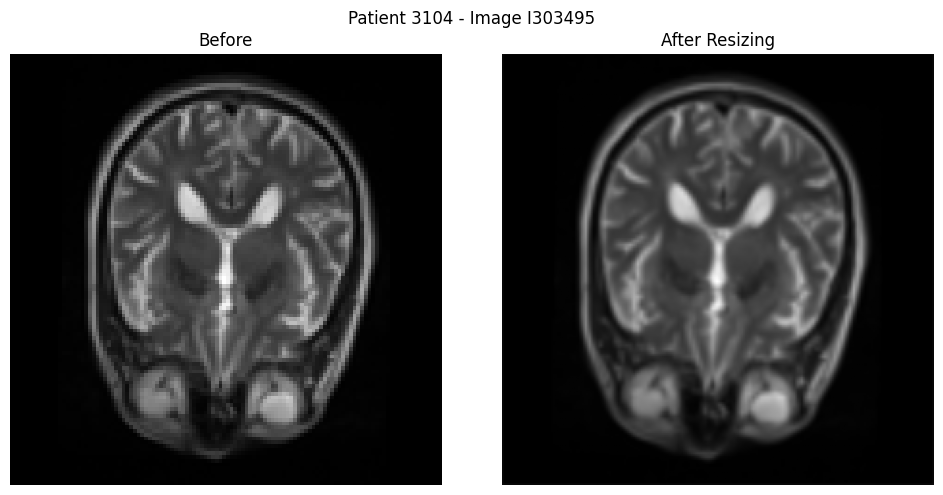


[3/721] Resizing: patient 3104 - image I330131...
Original Shape: (176, 240, 256)
Resized Shape: (224, 224, 128)


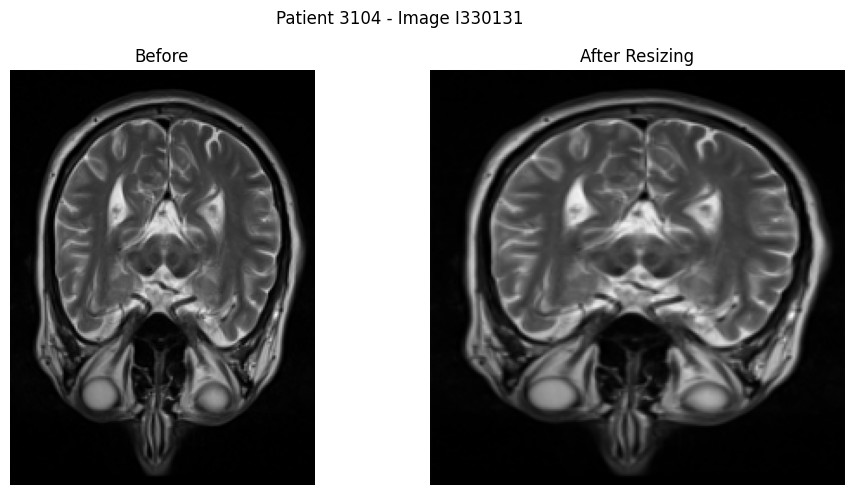


[4/721] Resizing: patient 3105 - image I406732...
Original Shape: (116, 116, 72)
Resized Shape: (224, 224, 128)


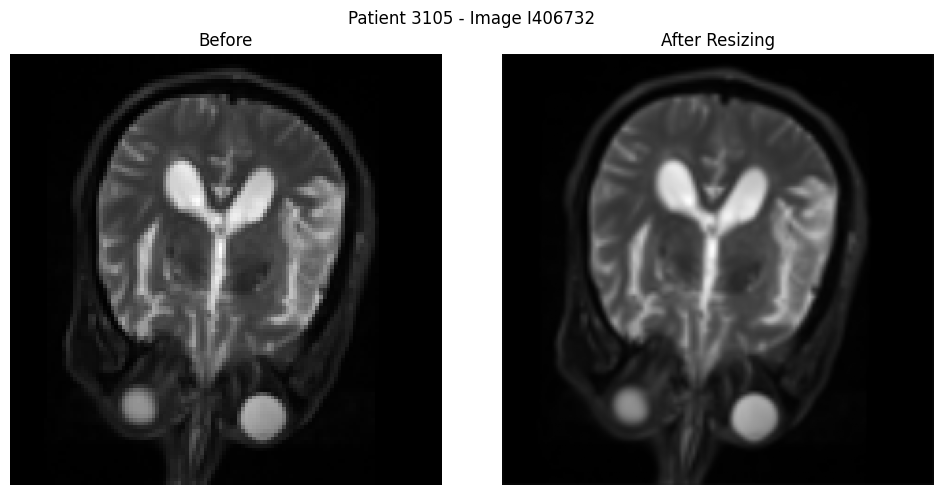


[5/721] Resizing: patient 3105 - image I406740...
Original Shape: (176, 240, 256)
Resized Shape: (224, 224, 128)


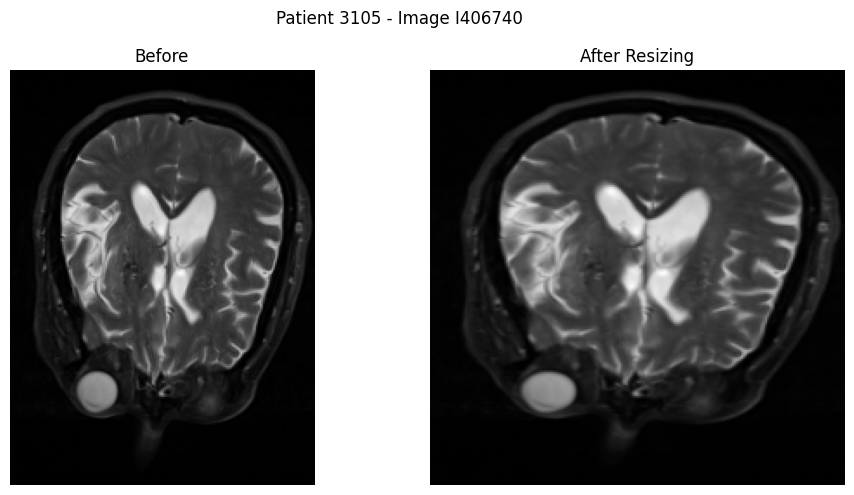


[6/721] Resizing: patient 3107 - image I304299...
Original Shape: (116, 116, 72)
Resized Shape: (224, 224, 128)

[7/721] Resizing: patient 3107 - image I304310...
Original Shape: (116, 116, 72)
Resized Shape: (224, 224, 128)

[8/721] Resizing: patient 3107 - image I330465...
Original Shape: (176, 240, 256)
Resized Shape: (224, 224, 128)

[9/721] Resizing: patient 3107 - image I429657...
Original Shape: (116, 116, 72)
Resized Shape: (224, 224, 128)

[10/721] Resizing: patient 3107 - image I429659...
Original Shape: (176, 240, 256)
Resized Shape: (224, 224, 128)

[11/721] Resizing: patient 3107 - image I693251...
Original Shape: (116, 116, 72)
Resized Shape: (224, 224, 128)

[12/721] Resizing: patient 3107 - image I696120...
Original Shape: (176, 240, 256)
Resized Shape: (224, 224, 128)

[13/721] Resizing: patient 3108 - image I330490...
Original Shape: (176, 240, 256)
Resized Shape: (224, 224, 128)

[14/721] Resizing: patient 3108 - image I333077...
Original Shape: (116, 116, 72)
Resiz

In [11]:
total_images = sum(
    1 for root, dirs, files in os.walk(normalized_path)
    for file in files if file.endswith(".nii") or file.endswith(".nii.gz")
)
processed_count = 0
displayed_count = 0
failed_resizing = []

# (X=width, Y=height, Z=depth;number of slices)
target_shape = (224, 224, 128)

resized_path = "Dataset/mri_t2_images/Resized_mri_t2(not paired)"
os.makedirs(resized_path, exist_ok=True)

# Helper: resize full 3D volume to fixed shape
def resize_volume(data, new_shape=(240, 240, 72)):
    resized = resize(
        data,
        new_shape,
        mode="constant",  # fill missing with 0
        cval=0,
        anti_aliasing=True,
        order=1  # interpolation; 3 for patterns and textures, 1 for precise voxel intensity
    )

    return resized


for patient_id in os.listdir(normalized_path):
    patient_path = os.path.join(normalized_path, patient_id)
    if not os.path.isdir(patient_path):
        continue

    for file in os.listdir(patient_path):
        if not (file.endswith(".nii") or file.endswith(".nii.gz")):
            continue
        processed_count += 1

        img_id = os.path.splitext(os.path.splitext(file)[0])[0]
        print(f"\n[{processed_count}/{total_images}] Resizing: patient {patient_id} - image {img_id}...")

        input_path = os.path.join(patient_path, file)

        # Output folder
        patient_output_dir = os.path.join(resized_path, patient_id)
        os.makedirs(patient_output_dir, exist_ok=True)
        output_file = os.path.join(patient_output_dir, file)

        try:
            # Load normalized MRI
            img = nib.load(input_path)
            data = img.get_fdata()
            print("Original Shape:", data.shape)

            # Resize (slice by slice)
            resized_data = resize_volume(data, new_shape=target_shape)
            print("Resized Shape:", resized_data.shape)

            # Display BEFORE/AFTER for first few cases
            if displayed_count < MAX_DISPLAYED:
                fig, axes = plt.subplots(1, 2, figsize=(10, 5))
                plt.suptitle(f"Patient {patient_id} - Image {img_id}")

                display_nifti_img(data, ax=axes[0], title="Before")
                display_nifti_img(resized_data, ax=axes[1], title="After Resizing")

                plt.tight_layout()
                plt.show()

                displayed_count += 1

            # Save new resized NIfTI image
            nib.save(
                nib.Nifti1Image(resized_data, affine=img.affine, header=img.header),
                output_file
            )

        except Exception as e:
            print(f"[✘] Failed to resize {patient_id}/{img_id}: {e}")
            failed_resizing.append(f"{patient_id}/{img_id}")

# ===============================
# Final Summary
# ===============================
print("\n" + "=" * 50)
if not failed_resizing:
    print("✅ All images resized successfully.")
else:
    print(f"⚠ {len(failed_resizing)} images failed to resize:")
    for img_name in failed_resizing:
        print(f" - {img_name}")

## Merge all PPMI_ (MRI) folders

### check for duplicates patients

In [17]:
from collections import defaultdict

# Path where PPMI_1 to PPMI_5 folders live
base_path = "Dataset/mri_t2_images"

# Store patients by which PPMI folder they appear in
patient_folders = defaultdict(list)

# Loop over each PPMI folder
for folder_name in sorted(os.listdir(base_path)):
    folder_path = os.path.join(base_path, folder_name)

    if os.path.isdir(folder_path) and folder_name.startswith("PPMI_"):
        # Each patient is usually a subfolder (adjust if stored differently)
        for patient_id in os.listdir(folder_path):
            patient_folders[patient_id].append(folder_name)

# Find duplicates
duplicates = {pid: locations for pid, locations in patient_folders.items() if len(locations) > 1}

# Report results
if duplicates:
    print("⚠ Found patients in multiple PPMI folders:")
    for pid, locations in duplicates.items():
        print(f" - Patient {pid} found in: {', '.join(locations)}")
else:
    print("✅ No duplicate patients found across PPMI_1 to PPMI_5")


⚠ Found patients in multiple PPMI folders:
 - Patient 3107 found in: PPMI_1, PPMI_4, PPMI_5
 - Patient 3111 found in: PPMI_1, PPMI_3, PPMI_5
 - Patient 3115 found in: PPMI_1, PPMI_2
 - Patient 3116 found in: PPMI_1, PPMI_2, PPMI_3, PPMI_4
 - Patient 3118 found in: PPMI_1, PPMI_2, PPMI_3, PPMI_5
 - Patient 3119 found in: PPMI_1, PPMI_3, PPMI_4, PPMI_5
 - Patient 3122 found in: PPMI_1, PPMI_5
 - Patient 3124 found in: PPMI_1, PPMI_4, PPMI_5
 - Patient 3127 found in: PPMI_1, PPMI_4
 - Patient 3130 found in: PPMI_1, PPMI_2, PPMI_3, PPMI_4
 - Patient 3132 found in: PPMI_1, PPMI_2, PPMI_4, PPMI_5
 - Patient 3151 found in: PPMI_1, PPMI_5
 - Patient 3154 found in: PPMI_1, PPMI_2, PPMI_3, PPMI_4, PPMI_5
 - Patient 3157 found in: PPMI_1, PPMI_2
 - Patient 3165 found in: PPMI_1, PPMI_4, PPMI_5
 - Patient 3168 found in: PPMI_1, PPMI_4, PPMI_5
 - Patient 3172 found in: PPMI_1, PPMI_2
 - Patient 3173 found in: PPMI_1, PPMI_3
 - Patient 3175 found in: PPMI_1, PPMI_5
 - Patient 3176 found in: PPMI_1, 

### check for duplicates images per patient

In [18]:
# Step 1: Map patients to which PPMI folders they appear in
patient_folders = defaultdict(list)

for folder_name in sorted(os.listdir(base_path)):
    folder_path = os.path.join(base_path, folder_name)

    if os.path.isdir(folder_path) and folder_name.startswith("PPMI_"):
        for patient_id in os.listdir(folder_path):
            patient_path = os.path.join(folder_path, patient_id)
            if os.path.isdir(patient_path):
                patient_folders[patient_id].append(patient_path)

# Step 2: Check duplicates by image_id (last folder name)
duplicates = {pid: paths for pid, paths in patient_folders.items() if len(paths) > 1}

if not duplicates:
    print("✅ No duplicate patients found.")
else:
    print(f"⚠ Found {len(duplicates)} duplicate patients.\n")

    for patient_id, paths in duplicates.items():
        image_id_sets = []

        for path in paths:
            image_ids = set()
            for root, dirs, files in os.walk(path):
                # If this folder has no subfolders and contains files, it's an image_id folder
                if files and not dirs:
                    image_id = os.path.basename(root)
                    image_ids.add(image_id)
            image_id_sets.append(image_ids)

        # Compare all sets of image_ids
        identical = all(image_id_sets[0] == ids for ids in image_id_sets[1:])

        print(f"Patient {patient_id}: {'YES - identical image IDs' if identical else 'NO - different image IDs'}")


⚠ Found 200 duplicate patients.

Patient 3107: NO - different image IDs
Patient 3111: NO - different image IDs
Patient 3115: NO - different image IDs
Patient 3116: NO - different image IDs
Patient 3118: NO - different image IDs
Patient 3119: NO - different image IDs
Patient 3122: NO - different image IDs
Patient 3124: NO - different image IDs
Patient 3127: NO - different image IDs
Patient 3130: NO - different image IDs
Patient 3132: NO - different image IDs
Patient 3151: NO - different image IDs
Patient 3154: NO - different image IDs
Patient 3157: NO - different image IDs
Patient 3165: NO - different image IDs
Patient 3168: NO - different image IDs
Patient 3172: NO - different image IDs
Patient 3173: NO - different image IDs
Patient 3175: NO - different image IDs
Patient 3176: NO - different image IDs
Patient 3178: NO - different image IDs
Patient 3179: NO - different image IDs
Patient 3182: NO - different image IDs
Patient 3185: NO - different image IDs
Patient 3190: NO - different im

### merge all 5 folders

In [20]:
import shutil


# Destination: merged single PPMI folder
output_dir = os.path.join(base_path, "PPMI_mri_t2")
os.makedirs(output_dir, exist_ok=True)

# Map: patient_id -> set of image_ids (to avoid duplicates)
patient_image_ids = defaultdict(set)

# Walk through all PPMI folders
for folder_name in sorted(os.listdir(base_path)):
    folder_path = os.path.join(base_path, folder_name)

    if os.path.isdir(folder_path) and folder_name.startswith("PPMI_"):
        for patient_id in os.listdir(folder_path):
            patient_path = os.path.join(folder_path, patient_id)
            if not os.path.isdir(patient_path):
                continue

            # Destination patient folder
            merged_patient_path = os.path.join(output_dir, patient_id)
            os.makedirs(merged_patient_path, exist_ok=True)

            # Walk through the substructure of each patient
            for scan_type in os.listdir(patient_path):
                scan_type_path = os.path.join(patient_path, scan_type)
                if not os.path.isdir(scan_type_path):
                    continue

                for date_folder in os.listdir(scan_type_path):
                    date_path = os.path.join(scan_type_path, date_folder)
                    if not os.path.isdir(date_path):
                        continue

                    for image_id in os.listdir(date_path):
                        image_id_path = os.path.join(date_path, image_id)
                        if not os.path.isdir(image_id_path):
                            continue

                        # Skip duplicate image_ids for the same patient
                        if image_id in patient_image_ids[patient_id]:
                            continue

                        # Mark image_id as seen
                        patient_image_ids[patient_id].add(image_id)

                        # Destination path preserving structure
                        merged_image_path = os.path.join(
                            merged_patient_path, scan_type, date_folder, image_id
                        )
                        os.makedirs(os.path.dirname(merged_image_path), exist_ok=True)

                        # Copy the entire image_id folder
                        shutil.copytree(image_id_path, merged_image_path)

print("✅ Merge complete! Output stored in:", output_dir)

✅ Merge complete! Output stored in: Dataset/mri_t2_images\PPMI_mri_t2


### verify total number of patients and images

#### in the 5 folders

In [21]:
ppmi_folders = [
    "Dataset/mri_t2_images/PPMI_1",
    "Dataset/mri_t2_images/PPMI_2",
    "Dataset/mri_t2_images/PPMI_3",
    "Dataset/mri_t2_images/PPMI_4",
    "Dataset/mri_t2_images/PPMI_5"
]

all_patients = set()
total_unique_images = 0

for folder in ppmi_folders:
    for patient_id in os.listdir(folder):
        patient_path = os.path.join(folder, patient_id)
        if not os.path.isdir(patient_path):
            continue

        all_patients.add(patient_id)

        # Track unique image IDs for this patient inside this folder
        patient_image_ids = set()

        for scan_type in os.listdir(patient_path):
            scan_type_path = os.path.join(patient_path, scan_type)
            if not os.path.isdir(scan_type_path):
                continue

            for date_folder in os.listdir(scan_type_path):
                date_path = os.path.join(scan_type_path, date_folder)
                if not os.path.isdir(date_path):
                    continue

                for image_id in os.listdir(date_path):
                    if os.path.isdir(os.path.join(date_path, image_id)):
                        patient_image_ids.add(image_id)

        total_unique_images += len(patient_image_ids)

print(f"📌 Total unique patients: {len(all_patients)}")
print(f"📌 Total unique image IDs: {total_unique_images}")

📌 Total unique patients: 207
📌 Total unique image IDs: 721


#### in the merged folder

In [22]:
merged_path = "Dataset/mri_t2_images/PPMI_mri_t2"

all_patients = set()
total_unique_images = 0

for patient_id in os.listdir(merged_path):
    patient_path = os.path.join(merged_path, patient_id)
    if not os.path.isdir(patient_path):
        continue

    all_patients.add(patient_id)

    # Track unique image IDs for this patient
    patient_image_ids = set()

    for scan_type in os.listdir(patient_path):
        scan_type_path = os.path.join(patient_path, scan_type)
        if not os.path.isdir(scan_type_path):
            continue

        for date_folder in os.listdir(scan_type_path):
            date_path = os.path.join(scan_type_path, date_folder)
            if not os.path.isdir(date_path):
                continue

            for image_id in os.listdir(date_path):
                if os.path.isdir(os.path.join(date_path, image_id)):
                    patient_image_ids.add(image_id)

    # Add this patient's unique image count to the total
    total_unique_images += len(patient_image_ids)

print(f"📌 Total unique patients: {len(all_patients)}")
print(f"📌 Total unique image IDs: {total_unique_images}")

📌 Total unique patients: 207
📌 Total unique image IDs: 721
